**Further train DeepCell Models with K's Data and Make Predictions**<br>
Starting from model trained with tn nuclear data, further train the model with resized K's data that is cut into 25x7 512x512 patches and masks on the lines are removed along with pixels identified as in the masks on the lines.<br>
200 epochs, semanticdatagenerator, resized<br>
Best mAP 0.48 at mpp=1.3

In [1]:
starting_model_path = 'tn1.0_nuclear_20221102.h5' # the model trained with nucleus data from the Tissuenet V1.0 dataset
INPUT_PATH="images/training_resized_512x512_a/"
model_name = 'tn1.0_nuclear_K_512x512resized_a' 
model_path = '{}.h5'.format(model_name)
epochs=200 # 20 sec per step 

In [2]:
import syotil

import numpy as np
from skimage import io
from matplotlib import pyplot as plt
%matplotlib inline
from timeit import default_timer
import os
from skimage import img_as_ubyte

import deepcell
from deepcell import image_generators
from deepcell.utils.train_utils import rate_scheduler, get_callbacks, count_gpus
from deepcell_toolbox.utils import resize, tile_image, untile_image
from deepcell_toolbox.deep_watershed import deep_watershed
from deepcell.losses import weighted_categorical_crossentropy
from deepcell.model_zoo.panopticnet import PanopticNet

import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import MSE

print(tf.__version__)
print(deepcell.__version__)

2.7.1
0.11.1


In [3]:
import glob
FILENAMES = glob.glob(INPUT_PATH+"*_img.png")
print(len(FILENAMES))
print(FILENAMES)

175
['images/training_resized_512x512_a/M872956_JML_Position8_CD8_train21_img.png', 'images/training_resized_512x512_a/M872956_JML_Position10_CD3_train13_img.png', 'images/training_resized_512x512_a/M872956_JML_Position9_CD3_train20_img.png', 'images/training_resized_512x512_a/M872956_JML_Position8_CD8_train6_img.png', 'images/training_resized_512x512_a/M926910_CFL_Position7_CD3_train24_img.png', 'images/training_resized_512x512_a/M926910_CFL_Position7_CD3_train4_img.png', 'images/training_resized_512x512_a/M872956_JML_Position8_CD3_train1_img.png', 'images/training_resized_512x512_a/M872956_JML_Position10_CD3_train21_img.png', 'images/training_resized_512x512_a/M872956_JML_Position8_CD8_train17_img.png', 'images/training_resized_512x512_a/M872956_JML_Position9_CD3_train15_img.png', 'images/training_resized_512x512_a/M872956_JML_Position10_CD3_train7_img.png', 'images/training_resized_512x512_a/M926910_CFL_Position7_CD3_train5_img.png', 'images/training_resized_512x512_a/M872956_JML_Po

In [4]:
imgs = [io.imread(CURR_IM_NAME) for CURR_IM_NAME in FILENAMES]
X_train = tf.stack(imgs)
X_train = np.expand_dims(X_train, axis=-1)
print(X_train.shape)

masks = [io.imread(CURR_IM_NAME.replace("img","masks")) for CURR_IM_NAME in FILENAMES]
y_train = tf.stack(masks)
y_train = np.expand_dims(y_train, axis=-1)
print(y_train.shape)

2022-11-05 14:15:39.478663: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14657 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:04:00.0, compute capability: 7.0
2022-11-05 14:15:39.480065: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14657 MB memory:  -> device: 1, name: Tesla V100-PCIE-16GB, pci bus id: 0000:06:00.0, compute capability: 7.0
2022-11-05 14:15:39.481260: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 14657 MB memory:  -> device: 2, name: Tesla V100-PCIE-16GB, pci bus id: 0000:08:00.0, compute capability: 7.0


(175, 512, 512, 1)
(175, 512, 512, 1)


In [5]:
np.max(masks) # sanity check

2688

In [6]:
# create dataloader
seed=0
min_objects = 5

transforms = ['inner-distance', 'outer-distance', 'fgbg']
transforms_kwargs = {'outer-distance': {'erosion_width': 0}}

# use augmentation for training but not validation
datagen = image_generators.SemanticDataGenerator(
    rotation_range=180,
    fill_mode='reflect',
    zoom_range=(0.75, 1.25),
    horizontal_flip=True,
    vertical_flip=True)

datagen_val = image_generators.CroppingDataGenerator()

batch_size = 4 # 8 causes memory outage

train_data = datagen.flow(
    {'X': X_train, 'y': y_train},
    seed=seed,
    transforms=transforms,
    transforms_kwargs=transforms_kwargs,
    min_objects=min_objects,
    batch_size=batch_size)

val_data = None
# datagen_val.flow(
#     {'X': X_val, 'y': y_val},
#     seed=seed,
#     transforms=transforms,
#     transforms_kwargs=transforms_kwargs,
#     min_objects=min_objects,
#     batch_size=batch_size)

# get number of training and validation instances

cnts_train = [np.max(y_train[i,...]) for i in range(y_train.shape[0])]
print(np.sum(cnts_train)) # total number of training instances

302812


In [7]:
mask_cnt=[len(np.unique(x)) for x in masks]
print(np.sort(mask_cnt))
indices = [mask_cnt.index(1)]
indices.extend([i for i, x in enumerate(mask_cnt) if x == 1])
indices.extend([i for i, x in enumerate(mask_cnt) if x == 2])
indices.extend([i for i, x in enumerate(mask_cnt) if x == 4])
print(indices)

[  1   1   1   1   2   4   4   4   5   5   6   6   7   7   8   8   9   9
  11  13  13  14  15  15  16  16  17  18  19  20  20  21  22  23  23  25
  25  26  26  27  29  29  30  32  33  33  34  35  36  38  38  39  39  39
  39  40  41  41  42  43  43  44  44  44  44  45  45  48  49  49  49  49
  50  51  51  52  52  55  57  58  58  59  59  59  61  61  63  65  65  66
  66  68  68  70  70  72  72  74  75  76  77  78  79  79  80  81  82  82
  82  83  84  84  85  88  88  89  89  89  89  89  92  94  95  95  98  99
 101 101 102 102 102 102 102 103 103 104 104 106 109 114 115 115 115 115
 118 120 120 123 124 125 127 128 129 130 132 135 136 143 143 144 144 144
 146 147 149 153 153 160 161 163 165 171 178 178 182]
[42, 42, 67, 143, 151, 120, 18, 128, 136]


136
images/training_resized_512x512_a/M872956_JML_Position8_CD4_train9_img.png


/app/software/scikit-image/0.19.1-foss-2021b/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


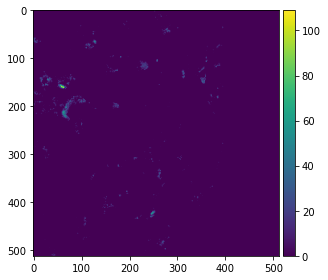

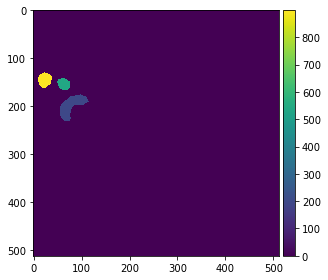

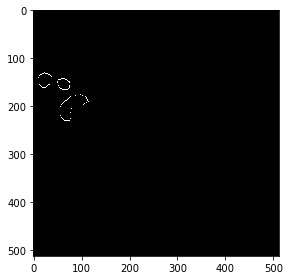

[  0 194 539 899]
[  0 194 539 899]


In [8]:
i=indices[-1]
print(i)
print(FILENAMES[i])
# plt.subplot(1, 3, 1) 
io.imshow(io.imread(FILENAMES[i]))
plt.show()
# plt.subplot(1, 3, 2) 
io.imshow(io.imread(FILENAMES[i].replace("_img","_masks")))
plt.show()
# plt.subplot(1, 3, 3) 
tmp=syotil.masks_to_outlines(io.imread(FILENAMES[i].replace("_img","_masks")))
io.imshow(tmp)
plt.show()
print(np.unique(masks[i]))
print(np.unique(masks[i][1:510,1:510]))

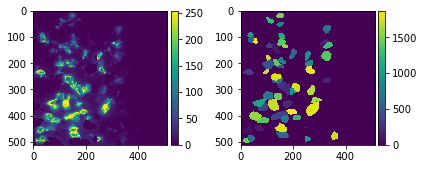

In [9]:
i=5
plt.subplot(1, 2, 1) # row 1, col 2 index 1
io.imshow(X_train[i,:,:,0])
plt.subplot(1, 2, 2) # row 1, col 2 index 1
io.imshow(y_train[i,:,:,0])
plt.show()

**The two cells below define and train the model.** They can be skipped if a trained model will be loaded.

In [10]:
semantic_classes = [1, 1, 2] # inner distance, outer distance, fgbg

model = PanopticNet(
    backbone='resnet50',
    input_shape=(512,512,1),
    norm_method='whole_image',
    num_semantic_classes=semantic_classes)

lr = 1e-4
optimizer = Adam(lr=lr, clipnorm=0.001)
lr_sched = rate_scheduler(lr=lr, decay=0.99)

# Create a dictionary of losses for each semantic head

def semantic_loss(n_classes):
    def _semantic_loss(y_pred, y_true):
        if n_classes > 1:
            return 0.01 * weighted_categorical_crossentropy(
                y_pred, y_true, n_classes=n_classes)
        return MSE(y_pred, y_true)
    return _semantic_loss

loss = {}

# Give losses for all of the semantic heads
for layer in model.layers:
    if layer.name.startswith('semantic_'):
        n_classes = layer.output_shape[-1]
        loss[layer.name] = semantic_loss(n_classes)
        
model.compile(loss=loss, optimizer=optimizer)

model.load_weights(starting_model_path, by_name=True)

[(layer.name, layer.output_shape) for layer in filter(lambda x: x.name.startswith('semantic_'), model.layers)]

2022-11-05 14:15:49.291567: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/app/software/TensorFlow/2.7.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[('semantic_0', (None, 512, 512, 1)),
 ('semantic_1', (None, 512, 512, 1)),
 ('semantic_2', (None, 512, 512, 2))]

In [11]:
# fit the model
print('Training on', count_gpus(), 'GPUs.')

train_callbacks = get_callbacks(
    model_path,
    lr_sched=lr_sched,
#     monitor="val_loss",
    # monitor='loss', # training loss
    verbose=1)          
            
loss_history = model.fit(
    train_data,
    steps_per_epoch=train_data.y.shape[0] // batch_size, # 
    epochs=epochs, 
#     validation_data=val_data,
#     validation_steps=val_data.y.shape[0] // batch_size,
    callbacks=train_callbacks)

model.save_weights(model_path)

Training on 3 GPUs.


2022-11-05 14:15:56.277817: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 14657 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:04:00.0, compute capability: 7.0
2022-11-05 14:15:56.278719: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:1 with 14657 MB memory:  -> device: 1, name: Tesla V100-PCIE-16GB, pci bus id: 0000:06:00.0, compute capability: 7.0
2022-11-05 14:15:56.279600: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:2 with 14657 MB memory:  -> device: 2, name: Tesla V100-PCIE-16GB, pci bus id: 0000:08:00.0, compute capability: 7.0


Epoch 1/200


2022-11-05 14:16:16.359256: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8202


41/41 [==============================] - 62s 620ms/step - loss: 0.0150 - semantic_0_loss: 0.0036 - semantic_1_loss: 0.0093 - semantic_2_loss: 0.0021 - lr: 1.0000e-04
Epoch 2/200
41/41 [==============================] - 22s 531ms/step - loss: 0.0127 - semantic_0_loss: 0.0031 - semantic_1_loss: 0.0081 - semantic_2_loss: 0.0015 - lr: 9.9000e-05
Epoch 3/200
41/41 [==============================] - 22s 525ms/step - loss: 0.0121 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0077 - semantic_2_loss: 0.0015 - lr: 9.8010e-05
Epoch 4/200
41/41 [==============================] - 22s 532ms/step - loss: 0.0121 - semantic_0_loss: 0.0030 - semantic_1_loss: 0.0077 - semantic_2_loss: 0.0015 - lr: 9.7030e-05
Epoch 5/200
41/41 [==============================] - 22s 525ms/step - loss: 0.0117 - semantic_0_loss: 0.0029 - semantic_1_loss: 0.0075 - semantic_2_loss: 0.0014 - lr: 9.6060e-05
Epoch 6/200
41/41 [==============================] - 22s 524ms/step - loss: 0.0119 - semantic_0_loss: 0.0029 - semantic_1_

**Make prediction on K's data.**<br>
Using NuclearSegmentation allows setting image_mpp, which has a substantial influence on performance.

In [12]:
prediction_model = PanopticNet(
    backbone='resnet50',
    norm_method='whole_image',
    num_semantic_classes=[1, 1], # inner distance, outer distance
    input_shape= (512,512,1)
)

prediction_model.load_weights(model_path, by_name=True)

In [13]:
from deepcell.applications import NuclearSegmentation
app = NuclearSegmentation(prediction_model)
[(layer.name, layer.output_shape) for layer in filter(lambda x: x.name.startswith('semantic_'), app.model.layers)]

[('semantic_0', (None, 512, 512, 1)), ('semantic_1', (None, 512, 512, 1))]

In [14]:
import os
print(os.getcwd())
INPUT_PATH="images/test/"
FILENAMES = [f for f in os.listdir("images/training/testimages")]
print(FILENAMES)

/home/yfong/deeplearning/dense_cell_segmentation
['M926910_CFL_Position7_CD3_test_img.png', 'M872956_JML_Position10_CD3_test_img.png', 'M872956_JML_Position8_CD8_test_img.png', 'M926910_CFL_Position13_CD3_test_img.png', 'M872956_JML_Position8_CD3_test_img.png', 'M872956_JML_Position8_CD4_test_img.png', 'M872956_JML_Position9_CD3_test_img.png']


In [15]:
# more detailed mapping of image_mpp parameter
mpps=np.linspace(start=1, stop=2, num=6)

AP_mat=[]
for CURR_IM_NAME in FILENAMES:
    print(CURR_IM_NAME)
    im0 = io.imread(os.path.join(INPUT_PATH, CURR_IM_NAME))
    mask_true=io.imread(os.path.join(INPUT_PATH, CURR_IM_NAME.replace("img","masks")))

    x = np.expand_dims(im0, axis=-1)
    x = np.expand_dims(x, axis=0)
    y, tile_info = app._tile_input(x)
    AP_arr=[]
    for mpp in mpps:
        prd = app._untile_output(app.predict(y, image_mpp=mpp), tile_info)[0,:,:,0]
        a=syotil.csi(mask_true, prd)
        AP_arr.append(a)
    AP_mat.append(AP_arr)
print(AP_mat)
print(mpps)
[x.index(np.max(x)) for x in AP_mat]

M926910_CFL_Position7_CD3_test_img.png


/app/software/DeepCell/0.11.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/deepcell_toolbox/deep_watershed.py:179: FutureWarning: `selem` is a deprecated argument name for `h_maxima`. It will be removed in version 1.0.Please use `footprint` instead.
  markers = h_maxima(image=maxima,


M872956_JML_Position10_CD3_test_img.png
M872956_JML_Position8_CD8_test_img.png
M926910_CFL_Position13_CD3_test_img.png
M872956_JML_Position8_CD3_test_img.png
M872956_JML_Position8_CD4_test_img.png
M872956_JML_Position9_CD3_test_img.png
[[0.41237113402061853, 0.4224683544303797, 0.42410714285714285, 0.42411347517730497, 0.4038961038961039, 0.3621495327102804], [0.3973634651600753, 0.44206773618538325, 0.47332185886402756, 0.47317073170731705, 0.4245562130177515, 0.3684210526315789], [0.42857142857142855, 0.47641509433962265, 0.4772727272727273, 0.4297520661157025, 0.40625, 0.3411371237458194], [0.30666666666666664, 0.3556701030927835, 0.36342592592592593, 0.3554083885209713, 0.33739837398373984, 0.3171171171171171], [0.49245283018867925, 0.5505415162454874, 0.578397212543554, 0.533442088091354, 0.5076687116564417, 0.43626062322946174], [0.6207865168539326, 0.6015625, 0.5907990314769975, 0.5244444444444445, 0.47520661157024796, 0.4329501915708812], [0.3747276688453159, 0.4288747346072187

[3, 2, 2, 2, 2, 0, 3]

In [16]:
mpp_select=1.0

APs={}
for CURR_IM_NAME in FILENAMES:
    im0 = io.imread(os.path.join(INPUT_PATH, CURR_IM_NAME))
    mask_true=io.imread(os.path.join(INPUT_PATH, CURR_IM_NAME.replace("img","masks")))

    x = np.expand_dims(im0, axis=-1)
    x = np.expand_dims(x, axis=0)
    y, tile_info = app._tile_input(x)
    print(x.shape)
    print(y.shape)
    print(tile_info)
    pred = app.predict(y, image_mpp=mpp_select)
    prd = app._untile_output(pred, tile_info)
    #io.imshow(prd[0,:,:,0])
    plt.show()
    
    APs[CURR_IM_NAME] = syotil.csi(mask_true, prd[0,:,:,0])# masks may lose one pixel if dimension is odd pixels

APs["mAP"]=np.mean(list(APs.values()))
print(APs)

(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}
(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}
(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}
(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}
(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}
(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}
(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}
{'M926910_CFL_Position7_CD3_test_img.png': 0.41237113402061853, 'M872956_JML_Position10_CD3_test_img.png': 0.3973634651600753, 'M872956_JML_Position8_CD8_test_img.png': 0.42857142857142855, 'M926910_CFL_Position13_CD3_test_img.png': 0.30666666666666664, 'M872956_JML_Position8_CD3_test_img.png': 0.49245283018867925, 'M872956_JM

In [17]:
mpp_select=1.3

APs={}
for CURR_IM_NAME in FILENAMES:
    im0 = io.imread(os.path.join(INPUT_PATH, CURR_IM_NAME))
    mask_true=io.imread(os.path.join(INPUT_PATH, CURR_IM_NAME.replace("img","masks")))

    x = np.expand_dims(im0, axis=-1)
    x = np.expand_dims(x, axis=0)
    y, tile_info = app._tile_input(x)
    print(x.shape)
    print(y.shape)
    print(tile_info)
    pred = app.predict(y, image_mpp=mpp_select)
    prd = app._untile_output(pred, tile_info)
    #io.imshow(prd[0,:,:,0])
    plt.show()
    
    APs[CURR_IM_NAME] = syotil.csi(mask_true, prd[0,:,:,0])# masks may lose one pixel if dimension is odd pixels

APs["mAP"]=np.mean(list(APs.values()))
print(APs)

(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}
(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}
(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}
(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}
(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}
(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}
(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}
{'M926910_CFL_Position7_CD3_test_img.png': 0.42725880551301687, 'M872956_JML_Position10_CD3_test_img.png': 0.4614035087719298, 'M872956_JML_Position8_CD8_test_img.png': 0.5124378109452736, 'M926910_CFL_Position13_CD3_test_img.png': 0.3349282296650718, 'M872956_JML_Position8_CD3_test_img.png': 0.5732368896925859, 'M872956_JML_P

In [18]:
import pandas as pd
df = pd.DataFrame([FILENAMES+["mAP"], list(APs.values())])
print(df.transpose())
df.to_csv('images/training/csi_'+model_name+'.txt', index=False, header=False)

                                         0         1
0   M926910_CFL_Position7_CD3_test_img.png  0.427259
1  M872956_JML_Position10_CD3_test_img.png  0.461404
2   M872956_JML_Position8_CD8_test_img.png  0.512438
3  M926910_CFL_Position13_CD3_test_img.png  0.334928
4   M872956_JML_Position8_CD3_test_img.png  0.573237
5   M872956_JML_Position8_CD4_test_img.png  0.619289
6   M872956_JML_Position9_CD3_test_img.png   0.44958
7                                      mAP  0.482591


**mAP**<br>
image_mpp=1:   0.43<br>
image_mpp=1.3: 0.48<br>